In [1]:
import os
import requests
import aiohttp
import asyncio
import nest_asyncio
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import openai

from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk import download as nltk_download
from langdetect import detect
from textblob import TextBlob
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud
from collections import Counter
from ast import literal_eval

# Download necessary NLTK data
nltk_download('punkt')
nltk_download('averaged_perceptron_tagger')
nltk_download('stopwords')
nltk_download('wordnet')

# Apply nest_asyncio
nest_asyncio.apply()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lok\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lok\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
async def getItem(query, options={'page': None, 'item': None, 'reviewPage': None}):
    # Construct the search URL for the first page
    search_url = f'https://www.amazon.com/s?k={query}'
#     user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36'
    user_agent = 'Mozilla/5.0'
    headers = {'User-Agent': user_agent, 'Accept-Language': 'en-us,en;q=0.5'}

    page = 0 if options['page'] else None
    item = options['item']
    reviewPage = 0 if options['reviewPage'] else None

    async def get_product_data(session, url):
        async with session.get(url, headers=headers) as response:
            html_content = await response.text()
            html_soup = BeautifulSoup(html_content, 'html.parser')
            
            # Extract the product title
            title = html_soup.find('span', {'id': 'productTitle'}).text.strip()
            print(title)
            # Extract the product price
            price_symbol = html_soup.find('div', {'id': 'corePriceDisplay_desktop_feature_div'}).find('span', {'class': 'a-price-symbol'}).text
            price_whole = html_soup.find('div', {'id': 'corePriceDisplay_desktop_feature_div'}).find('span', {'class': 'a-price-whole'}).text
            price_fraction = html_soup.find('div', {'id': 'corePriceDisplay_desktop_feature_div'}).find('span', {'class': 'a-price-fraction'}).text
            price = price_symbol + price_whole + price_fraction
            print(price)
            # Extract the product rating
            rating = html_soup.find('span', {'class': 'a-icon-alt'}).text.strip()

            # Extract the reviews URL
            reviews_url = html_soup.find('a', attrs={'data-hook': 'see-all-reviews-link-foot'})['href']
            reviews_url = 'https://www.amazon.com' + reviews_url

            return title, price, rating, reviews_url

    async def get_reviews(session, url):
        all_reviews = []
        
        while url is not None:
            async with session.get(url, headers=headers) as response:
                html_content = await response.text()
                html_soup = BeautifulSoup(html_content, 'html.parser')
                
                review_box = html_soup.find_all(class_="a-section review aok-relative", attrs={'data-hook': 'review'})
                
                for review in review_box:
                    rev = []
                    rating = review.find('span', class_='a-icon-alt').string[0]
                    date_loc = review.find('span', attrs={'data-hook': 'review-date'}).string
                    date = re.search('(?<=on)(.*)', date_loc).group(0)
                    try:
                        if review.find('span', attrs={'data-hook': 'review-body'}).contents[1]:
                            comment = review.find('span', attrs={'data-hook': 'review-body'}).contents[1].contents[0]
                        else:
                            comment = None
                    except:
                        comment = None
                    rev.extend([date, rating, comment])
                    all_reviews.append(rev)
                    
                outer_box = html_soup.find(id='cm_cr-pagination_bar')
                
                if(outer_box):
                    if (outer_box.find('li', class_='a-last') is None) or (outer_box.find('li', class_='a-disabled a-last') is not None):
                        url = None
                    else:
                        next_page = outer_box.find('li', class_='a-last')
                        path = next_page.find('a', href=True)
                        print(path)
                        url = 'https://www.amazon.com/' + path['href']
                        if 'ap/signin' in url:
                            url = None
                    print(url)

                if options['reviewPage']:
                    reviewPage += 1
                    if(reviewPage>=options['reviewPage']):
                        url = None
                
        
        return all_reviews

    async def process_product(session, url):
        title, price, rating, reviews_url = await get_product_data(session, url)
        all_reviews = await get_reviews(session, reviews_url)
        return {
            'title': title,
            'price': price,
            'rating': rating,
            'reviews': all_reviews
        }

    async with aiohttp.ClientSession(headers=headers) as session:
        while search_url is not None:
            if options['page']:
                page += 1
                if page > options['page']:
                    break
            print(f"Page {page}")
            
            # Create an empty list to hold the URLs of all products
            product_urls = []

            # Make a GET request to the search results page
            async with session.get(search_url) as response:
                html_content = await response.text()
                soup = BeautifulSoup(html_content, 'html.parser')

            # Extract the URL of each product in the search results and add it to the list
            for link in soup.find_all('a', {'class': 'a-link-normal s-no-outline'}):
                product_urls.append(f'https://www.amazon.com{link["href"]}')
            
            if options['item']:
                product_urls = product_urls[:item]
            
            # Create a list of tasks to process each product
            tasks = [process_product(session, url) for url in product_urls]

            # Wait for all tasks to complete
            products_data = await asyncio.gather(*tasks)      
            
            # Print the results
            for product_data in products_data:
                print(f"Product Title: {product_data['title']}")
                print(f"Product Price: {product_data['price']}")
                print(f"Product Rating: {product_data['rating']}")
                print("Reviews:")
                df = pd.DataFrame(product_data['reviews'], columns=['Date', 'Rating', 'Comment'])
                print(df)
                print("\n")
                df.to_csv('data.csv', encoding='utf-8-sig', columns=['Date', 'Rating', 'Comment'])

            # Check if there is a link to the next page of results
            next_link = soup.find('a', {'class': 's-pagination-item s-pagination-next s-pagination-button s-pagination-separator'})
            search_url = f'https://www.amazon.com{next_link["href"]}' if next_link else None

asyncio.run(getItem('monitors',{'page': 1, 'item': 1, 'reviewPage': None}))

Page 1
Sceptre 24" Professional Thin 75Hz 1080p LED Monitor 2x HDMI VGA Build-in Speakers, Machine Black (E248W-19203R Series)
$114.20
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_2?ie=UTF8&amp;pageNumber=2&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_2?ie=UTF8&pageNumber=2&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_3?ie=UTF8&amp;pageNumber=3&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_3?ie=

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_20?ie=UTF8&amp;pageNumber=20&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_20?ie=UTF8&pageNumber=20&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_21?ie=UTF8&amp;pageNumber=21&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_21?ie=UTF8&pageNumber=21&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_38?ie=UTF8&amp;pageNumber=38&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_38?ie=UTF8&pageNumber=38&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_39?ie=UTF8&amp;pageNumber=39&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_39?ie=UTF8&pageNumber=39&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_56?ie=UTF8&amp;pageNumber=56&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_56?ie=UTF8&pageNumber=56&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_57?ie=UTF8&amp;pageNumber=57&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_57?ie=UTF8&pageNumber=57&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_74?ie=UTF8&amp;pageNumber=74&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_74?ie=UTF8&pageNumber=74&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_75?ie=UTF8&amp;pageNumber=75&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_75?ie=UTF8&pageNumber=75&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_92?ie=UTF8&amp;pageNumber=92&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_92?ie=UTF8&pageNumber=92&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_93?ie=UTF8&amp;pageNumber=93&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_93?ie=UTF8&pageNumber=93&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_110?ie=UTF8&amp;pageNumber=110&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_110?ie=UTF8&pageNumber=110&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_111?ie=UTF8&amp;pageNumber=111&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_111?ie=UTF8&pageNumber=111&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_128?ie=UTF8&amp;pageNumber=128&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_128?ie=UTF8&pageNumber=128&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_129?ie=UTF8&amp;pageNumber=129&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_129?ie=UTF8&pageNumber=129&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_146?ie=UTF8&amp;pageNumber=146&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_146?ie=UTF8&pageNumber=146&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_147?ie=UTF8&amp;pageNumber=147&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_147?ie=UTF8&pageNumber=147&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_164?ie=UTF8&amp;pageNumber=164&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_164?ie=UTF8&pageNumber=164&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_165?ie=UTF8&amp;pageNumber=165&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_165?ie=UTF8&pageNumber=165&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_182?ie=UTF8&amp;pageNumber=182&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_182?ie=UTF8&pageNumber=182&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_183?ie=UTF8&amp;pageNumber=183&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_183?ie=UTF8&pageNumber=183&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_200?ie=UTF8&amp;pageNumber=200&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_200?ie=UTF8&pageNumber=200&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_201?ie=UTF8&amp;pageNumber=201&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_201?ie=UTF8&pageNumber=201&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_218?ie=UTF8&amp;pageNumber=218&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_218?ie=UTF8&pageNumber=218&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_219?ie=UTF8&amp;pageNumber=219&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_219?ie=UTF8&pageNumber=219&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_236?ie=UTF8&amp;pageNumber=236&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_236?ie=UTF8&pageNumber=236&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_237?ie=UTF8&amp;pageNumber=237&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_237?ie=UTF8&pageNumber=237&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_254?ie=UTF8&amp;pageNumber=254&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_254?ie=UTF8&pageNumber=254&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_255?ie=UTF8&amp;pageNumber=255&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_255?ie=UTF8&pageNumber=255&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_272?ie=UTF8&amp;pageNumber=272&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_272?ie=UTF8&pageNumber=272&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_273?ie=UTF8&amp;pageNumber=273&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_273?ie=UTF8&pageNumber=273&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_290?ie=UTF8&amp;pageNumber=290&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_290?ie=UTF8&pageNumber=290&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_291?ie=UTF8&amp;pageNumber=291&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_291?ie=UTF8&pageNumber=291&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_308?ie=UTF8&amp;pageNumber=308&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_308?ie=UTF8&pageNumber=308&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_309?ie=UTF8&amp;pageNumber=309&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_309?ie=UTF8&pageNumber=309&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_326?ie=UTF8&amp;pageNumber=326&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_326?ie=UTF8&pageNumber=326&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_327?ie=UTF8&amp;pageNumber=327&amp;reviewerType=all_reviews">Next page<span class="a-letter-space"></span><span class="a-letter-space"></span><span class="larr">→</span></a>
https://www.amazon.com//Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B0773ZY26F/ref=cm_cr_arp_d_paging_btm_327?ie=UTF8&pageNumber=327&reviewerType=all_reviews
<a href="/Sceptre-E248W-19203R-Monitor-Speakers-Metallic/product-reviews/B07

In [2]:
df=pd.read_csv('./data.csv', encoding='utf-8-sig', low_memory=False)
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

In [3]:
df.head(5)

,Id,Date,Rating,Comment
0,0,"March 12, 2023",5,The monitor is very easy to set up and use. It...
1,1,"May 19, 2022",5,"I have bought sceptre monitors in the past, an..."
2,2,"February 18, 2023",4,I love this little monitor for the price. Perf...
3,3,"March 5, 2023",5,"Outstanding monitor, used for daily work and I..."
4,4,"March 9, 2023",5,I purchased two and put them side-by-side. The...


In [4]:
# Define a function to detect the language of each review
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

# Apply the language detection function to each comment in your DataFrame
df['Language'] = df['Comment'].apply(detect_language)

# Filter out any non-English reviews
df = df.loc[df['Language'] == 'en'].copy()

# Remove the 'Language' column from your DataFrame
df.drop('Language', axis=1, inplace=True)



In [5]:
# def softmax(x, dim=None):
#     if dim is None:
#         # Compute the softmax over the entire tensor
#         x = x.flatten()
#         dim = 0
#     max_x = torch.max(x, dim=dim, keepdim=True)[0]
#     exp_x = torch.exp(x - max_x)
#     sum_exp_x = torch.sum(exp_x, dim=dim, keepdim=True)
#     return exp_x / sum_exp_x

# Define a function to get the sentiment predictions using BERT
def get_sentiment_predictions(text):
    with torch.no_grad():
        # Tokenize the input text
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
        # Use the model to predict the sentiment
        outputs = model(**inputs)
    
    logits = outputs.logits
    
#     # Compute the softmax of the logits tensor
#     probs = softmax(logits, dim=1)

#     # Extract the scores for each sentiment label
#     scores = probs.squeeze().tolist()

#     # Map the scores to labels and return the result as a list of dicts
#     labels = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
#     result = [[{'label': label, 'score': score} for label, score in zip(labels, scores)]]
    
    sentiment = torch.argmax(logits, dim=1).item() + 1
    return sentiment


def label_mapping(score):     
    # Map the sentiment to star ratings
    if score in [1, 2]:
        return 'negative' 
    elif score in [4, 5]:
        return 'positive'
    else:
        return 'neutral'
    
# def label_sentiment(score):
#     if score > 0.25:
#         return 'positive'
#     elif score < 0:
#         return 'negative'
#     else:
#         return 'neutral'

# Clean up the 'Comment' column
df['Normalized_Comment'] = df['Comment'].apply(lambda x: re.sub('[^a-zA-Z\s]', '', x)) # remove non-alphabetic characters
df['Normalized_Comment'] = df['Normalized_Comment'].apply(lambda x: x.lower()) # convert text to lowercase
df['Normalized_Comment'] = df['Normalized_Comment'].apply(lambda x: word_tokenize(x)) # tokenize text
stop_words = set(stopwords.words('english')) # define stop words
df['Normalized_Comment'] = df['Normalized_Comment'].apply(lambda x: [word for word in x if word not in stop_words]) # remove stop words
lemmatizer = WordNetLemmatizer() # define lemmatizer
df['Normalized_Comment'] = df['Normalized_Comment'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x]) # lemmatize words
df['Normalized_Comment'] = df['Normalized_Comment'].apply(lambda x: ' '.join(x)) # join the list of words back into a string

# Add a new column for POS tagging
df['POS'] = df['Normalized_Comment'].apply(lambda x: pos_tag(word_tokenize(x)))

# Get the sentiment predictions using TextBlob
df['Sentiment_TextBlob'] = df['POS'].apply(lambda x: TextBlob(' '.join([word for word, pos in x if pos in ['NN', 'JJ', 'VB', 'RB']])).sentiment.polarity)
df['Sentiment_TextBlob'] = ((df['Sentiment_TextBlob'] + 1) / 2 * 4 + 1).round().astype(int)
df['Sentiment_TextBlob_Label'] = df['Sentiment_TextBlob'].apply(label_mapping)

# Get the sentiment predictions using LiYuan's model
tokenizer = AutoTokenizer.from_pretrained("LiYuan/amazon-review-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("LiYuan/amazon-review-sentiment-analysis")
df['Sentiment_BERT'] = df['Comment'].apply(get_sentiment_predictions)
df['Sentiment_BERT_Label'] = df['Sentiment_BERT'].apply(label_mapping)



# Display the cleaned and collated DataFrame
print(df.head())


   Id                Date  Rating  \
0   0      March 12, 2023       5   
1   1        May 19, 2022       5   
2   2   February 18, 2023       4   
3   3       March 5, 2023       5   
4   4       March 9, 2023       5   

                                             Comment  \
0  The monitor is very easy to set up and use. It...   
1  I have bought sceptre monitors in the past, an...   
2  I love this little monitor for the price. Perf...   
3  Outstanding monitor, used for daily work and I...   
4  I purchased two and put them side-by-side. The...   

                                  Normalized_Comment  \
0  monitor easy set use sleek thin design look gr...   
1  bought sceptre monitor past stand great budget...   
2  love little monitor price perfect using extend...   
3  outstanding monitor used daily work couldnt ha...   
4  purchased two put sidebyside there narrow fram...   

                                                 POS  Sentiment_TextBlob  \
0  [(monitor, NN), (easy, J

In [6]:
df.to_csv('data_clean.csv', encoding='utf-8-sig', columns = ['Id','Date','Rating','Comment','Normalized_Comment','POS','Sentiment_TextBlob','Sentiment_TextBlob_Label','Sentiment_BERT','Sentiment_BERT_Label'], index=False)

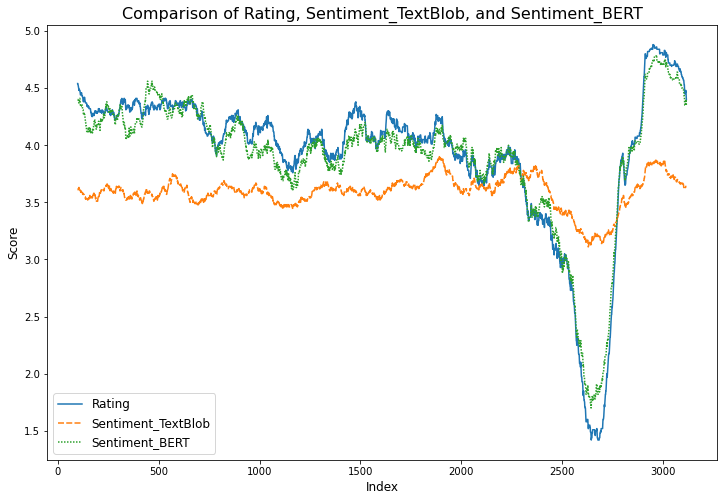

,Id,Date,Rating,Comment,Normalized_Comment,POS,Sentiment_TextBlob,Sentiment_TextBlob_Label,Sentiment_BERT,Sentiment_BERT_Label
0,0,"March 12, 2023",5,The monitor is very easy to set up and use. It...,monitor easy set use sleek thin design look gr...,"[('monitor', 'NN'), ('easy', 'JJ'), ('set', 'V...",3,neutral,5,positive
1,1,"May 19, 2022",5,"I have bought sceptre monitors in the past, an...",bought sceptre monitor past stand great budget...,"[('bought', 'VBN'), ('sceptre', 'NNS'), ('moni...",3,neutral,4,positive
2,2,"February 18, 2023",4,I love this little monitor for the price. Perf...,love little monitor price perfect using extend...,"[('love', 'VB'), ('little', 'JJ'), ('monitor',...",3,neutral,4,positive
3,3,"March 5, 2023",5,"Outstanding monitor, used for daily work and I...",outstanding monitor used daily work couldnt ha...,"[('outstanding', 'JJ'), ('monitor', 'NN'), ('u...",4,positive,5,positive
4,4,"March 9, 2023",5,I purchased two and put them side-by-side. The...,purchased two put sidebyside there narrow fram...,"[('purchased', 'VBN'), ('two', 'CD'), ('put', ...",3,neutral,5,positive
...,...,...,...,...,...,...,...,...,...,...
3110,3318,"August 18, 2020",5,Love the quality and just overall amazing,love quality overall amazing,"[('love', 'NN'), ('quality', 'NN'), ('overall'...",4,positive,5,positive
3111,3321,"July 30, 2020",5,Good experience so far,good experience far,"[('good', 'JJ'), ('experience', 'NN'), ('far',...",4,positive,5,positive
3112,3322,"March 18, 2021",1,"When I purchased it the screen was dim, black ...",purchased screen dim black looked like gray ev...,"[('purchased', 'VBN'), ('screen', 'JJ'), ('dim...",3,neutral,2,negative
3113,3324,"October 11, 2018",2,You get what you pay for. If you’re gonna buy ...,get pay youre gon na buy monitor cheap else yo...,"[('get', 'VB'), ('pay', 'JJ'), ('youre', 'NN')...",3,neutral,4,positive


In [18]:
df=pd.read_csv('./data_clean.csv', encoding='utf-8-sig', low_memory=False)


# Create a new DataFrame with the relevant columns
plot_df = df[['Rating', 'Sentiment_TextBlob', 'Sentiment_BERT']].copy()

# Calculate the rolling mean for each column to smooth the data
plot_df.loc[:, 'Rating'] = plot_df['Rating'].rolling(window=100).mean()
plot_df.loc[:, 'Sentiment_TextBlob'] = plot_df['Sentiment_TextBlob'].rolling(window=100).mean()
plot_df.loc[:, 'Sentiment_BERT'] = plot_df['Sentiment_BERT'].rolling(window=100).mean()

# Drop rows with NaN values
plot_df = plot_df.dropna()

# Plot the three line charts in one graph
plt.figure(figsize=(12, 8))
sns.lineplot(data=plot_df)
plt.title('Comparison of Rating, Sentiment_TextBlob, and Sentiment_BERT', fontsize=16)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(['Rating', 'Sentiment_TextBlob', 'Sentiment_BERT'], fontsize=12)
plt.show()

df

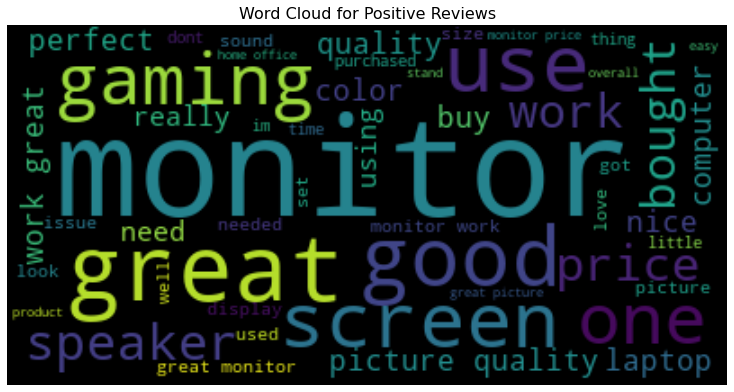

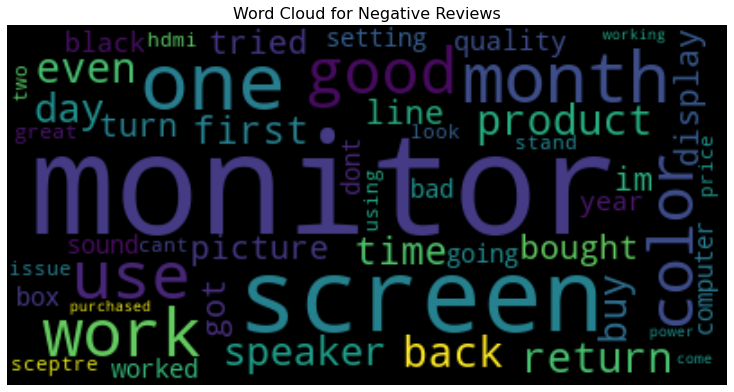

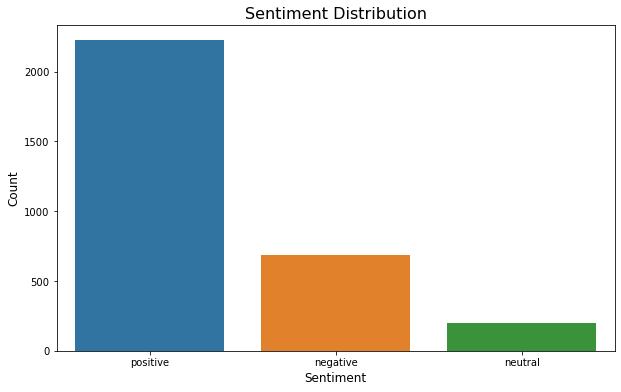

In [8]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(background_color='black', max_words=50, contour_width=3, contour_color='steelblue').generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout(pad=0)

positive_comments = ' '.join(df[df['Sentiment_BERT_Label'] == 'positive']['Normalized_Comment'].tolist())
negative_comments = ' '.join(df[df['Sentiment_BERT_Label'] == 'negative']['Normalized_Comment'].tolist())

generate_wordcloud(positive_comments, 'Word Cloud for Positive Reviews')
plt.show()

generate_wordcloud(negative_comments, 'Word Cloud for Negative Reviews')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment_BERT_Label', data=df)
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


In [9]:
# Join all POS tags into a single list
all_pos = [eval(pos) for pos in df['POS'].tolist()]

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Separate positive and negative adjectives using the VADER lexicon
positive_words = {}
negative_words = {}
for pos in all_pos:
    for i in range(len(pos)):
        word, tag = pos[i]
        if tag in ('JJ', 'JJR', 'JJS'):
            noun = None
            for j in range(i+1, len(pos)):
                if pos[j][1] in ('NN', 'NNS', 'NNP', 'NNPS'):
                    noun = pos[j][0]
                    break
            if noun:
                score = sia.polarity_scores(word)['compound']
                if score > 0:
                    positive_words[(word, noun)] = positive_words.get((word, noun), 0) + 1
                elif score < 0:
                    negative_words[(word, noun)] = negative_words.get((word, noun), 0) + 1

# Get top 50 most common positive and negative adjective-noun pairs
top_positive_pairs = Counter(positive_words).most_common(50)
top_negative_pairs = Counter(negative_words).most_common(50)

print('Top 50 positive adjective-noun pairs:\n')
for i in range(0, len(top_positive_pairs), 3):
    for pair in top_positive_pairs[i:i+3]:
        print(f'{(pair[0][0] + " " + pair[0][1]):<25} ({pair[1]:>3})', end='\t          ')
    print()

print('\nTop 50 negative adjective-noun pairs:\n')
for i in range(0, len(top_negative_pairs), 3):
    for pair in top_negative_pairs[i:i+3]:
        print(f'{(pair[0][0] + " " + pair[0][1]):<25} ({pair[1]:>3})', end='\t          ')
    print()
    

Top 50 positive adjective-noun pairs:

great monitor             (168)	          great picture             (117)	          good monitor              (105)	          
great price               ( 84)	          good price                ( 64)	          good quality              ( 54)	          
nice monitor              ( 49)	          great quality             ( 48)	          good picture              ( 45)	          
great value               ( 37)	          easy setup                ( 37)	          good value                ( 32)	          
clear picture             ( 31)	          good product              ( 31)	          great product             ( 27)	          
happy purchase            ( 25)	          great size                ( 21)	          easy set                  ( 21)	          
good size                 ( 20)	          nice picture              ( 20)	          happy monitor             ( 19)	          
worth money               ( 19)	          great speaker             ( 19

In [10]:
# Get list of POS tuples from dataframe
all_pos = []
for pos_str in df['POS']:
    try:
        pos_list = literal_eval(pos_str)
        all_pos.extend(pos_list)
    except:
        pass

# Define a BigramAssocMeasures object
bigram_measures = BigramAssocMeasures()

# Create a BigramCollocationFinder object
finder = BigramCollocationFinder.from_words(all_pos)

# Filter out collocations that appear less than 3 times
finder.apply_freq_filter(round(len(df) * 0.005))

# Filter to keep only adjective-noun (JJ-NN) and adverb-adjective (RB-JJ) bigrams
def filter_bigrams(w1, w2):
    _, t1 = w1
    _, t2 = w2
    return (t1 == 'JJ' and t2 == 'NN') or (t1 == 'RB' and t2 == 'JJ')

finder.apply_ngram_filter(filter_bigrams)

# Compute the top 10 collocations
top_collocations = finder.nbest(bigram_measures.pmi, 100)
    
# Print the top collocations in groups of 5
print('Top collocations (words only):\n')
for i in range(0, len(top_collocations), 5):
    collocations = [f'{c[0][0]} {c[1][0]}' for c in top_collocations[i:i+5]]
    format_string = ' '.join(['{:<25}'] * len(collocations))
    print(format_string.format(*collocations))




Top collocations (words only):

customer service          job done                  vesa mount                highly recommend          stopped working          
response time             dont know                 easy assemble             power cord                vga cable                
builtin speaker           definitely recommend      home office               hdmi port                 even though              
built speaker             hdmi cable                would recommend           year old                  easy set                 
speaker arent             hdmi cord                 price point               hdmi input                working home             
purchased two             especially price          would definitely          bought two                im using                 
would buy                 picture quality           image quality             work well                 another one              
two hdmi                  work home                 new on

In [11]:
# Define a function to extract features from the POS tags
def extract_features(pos):
    features = []
    for word, tag in pos:
        if tag.startswith('NN'):
            features.append(word)
        elif tag == 'JJ' and len(features) > 0:
            features[-1] = features[-1] + ' ' + word
    return features

df['Features'] = df['POS'].apply(lambda x: extract_features(eval(x)))

# Group reviews by rating
grouped_reviews = df.groupby('Sentiment_BERT_Label')['Features'].apply(lambda x: sum(x, [])).reset_index()

# Function to get top 1% most frequent words
def get_top_percent(words_list, percentage=0.01):
    count = Counter(words_list)
    top_count = int(len(count) * percentage)
    return count.most_common(top_count)

# Calculate the most frequent words for each rating group
results = {}
for index, row in grouped_reviews.iterrows():
    rating = row['Sentiment_BERT_Label']
    words = row['Features']
    top_words = get_top_percent(words)
    results[rating] = top_words

# Initialize the output string
output_string = ""

# Calculate and store the frequency count and percentage for each word in descending order of rating, 5 per row with spacing
for rating in sorted(results.keys(), reverse=True):
    words = results[rating]
    output_string += f"Most frequent features grouped with {rating} rating:\n"
    total_words = sum([word[1] for word in words])

    for i in range(0, len(words), 5):
        row_output = ""
        for j in range(i, min(i + 5, len(words))):
            word, count = words[j]
            percentage = count / total_words * 100
            row_output += f"{word}: {count}({percentage:.2f}%)".ljust(25)
        output_string += row_output + "\n"

    output_string += "\n"

# Print the output string
print(output_string)





Most frequent features grouped with positive rating:
monitor: 1114(18.25%)    price: 409(6.70%)        work: 320(5.24%)         picture: 311(5.10%)      quality: 277(4.54%)      
speaker: 245(4.01%)      use: 222(3.64%)          home: 190(3.11%)         screen: 169(2.77%)       office: 148(2.43%)       
hdmi: 145(2.38%)         computer: 123(2.02%)     color: 104(1.70%)        size: 98(1.61%)          work great: 88(1.44%)    
product: 87(1.43%)       love: 78(1.28%)          monitor great: 76(1.25%) setup: 73(1.20%)         issue: 72(1.18%)         
purchase: 67(1.10%)      time: 66(1.08%)          cable: 64(1.05%)         im: 63(1.03%)            value: 62(1.02%)         
display: 62(1.02%)       money: 62(1.02%)         game: 61(1.00%)          pc: 61(1.00%)            gaming: 61(1.00%)        
sound: 58(0.95%)         dont: 57(0.93%)          buy: 56(0.92%)           problem: 55(0.90%)       port: 54(0.88%)          
power: 51(0.84%)         thing: 47(0.77%)         monitor good: 4

In [12]:
openai.api_key = os.getenv("OPENAI_API_KEY")

# Define the prompt for the GPT-3 API
prompt = f"Please read the sentiment analysis results below, especially those product related properties, to guess the product then try to provide general feedback and business recommendation to the seller\n\n{output_string}\n\n"

# Generate comments using GPT-3
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

# Print the generated comments
print(response.choices[0].text)


Based on the sentiment analysis results, it appears that the product is a computer monitor. The frequent features associated with positive ratings indicate that customers are generally satisfied with the monitor's picture and quality, price, and the ease of use. The frequent features associated with neutral ratings suggest that customers may be indifferent to certain aspects of the monitor, such as the speaker and color. The frequent features associated with negative ratings reveal that customers may be dissatisfied with the monitor's power, product, and price.

General feedback to the seller: It appears that customers are generally satisfied with the monitor, but there are some areas that need improvement. Specifically, customers are dissatisfied with the monitor's power, product, and price.

Business recommendation to the seller: To address customers' dissatisfaction with the monitor's power, product, and price, the seller should consider offering discounts and promotions to incentiv